In [1]:
!nvidia-smi

Tue Dec 12 04:38:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr

In [1]:
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import transformers
print(transformers.__version__)


4.35.2


In [3]:
!pip install --upgrade pip

In [4]:
from datasets import load_dataset

In [5]:
!pip install sentencepiece
!pip install --no-cache-dir transformers sentencepiece

In [6]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=False)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

KeyboardInterrupt: ignored

In [9]:
from tqdm.notebook import tqdm
import torch

def generate_batch_sized_chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]

        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score


In [10]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][0]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


PEGASUS on SAMSum

In [11]:
"""
pipe = pipeline('summarization', model=model_ckpt)
pipe_out = pipe(dataset_samsum['test'][0]['dialogue'])
print(pipe_out)
"""

"\npipe = pipeline('summarization', model=model_ckpt)\npipe_out = pipe(dataset_samsum['test'][0]['dialogue'])\nprint(pipe_out)\n"

In [12]:
"""
pipe_out = pipe(dataset_samsum['test'][1]['dialogue'])
print(pipe_out)
"""

"\npipe_out = pipe(dataset_samsum['test'][1]['dialogue'])\nprint(pipe_out)\n"

In [13]:
"""
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_metric = load_metric('rouge')
score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8 )
"""

'\nrouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]\nrouge_metric = load_metric(\'rouge\')\nscore = calculate_metric_on_test_ds(dataset_samsum[\'test\'], rouge_metric, model_pegasus, tokenizer, column_text = \'dialogue\', column_summary=\'summary\', batch_size=8 )\n'

In [14]:
"""
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict, index = ['pegasus'])
"""

"\nrouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )\npd.DataFrame(rouge_dict, index = ['pegasus'])\n"

Histogram of Token Count

Token indices sequence length is longer than the specified maximum sequence length for this model (1044 > 1024). Running this sequence through the model will result in indexing errors


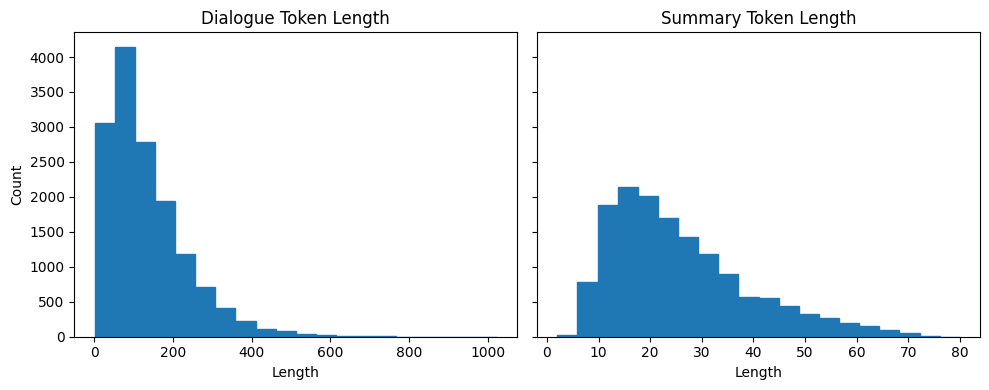

In [15]:
# Truncate or split sequences to fit within the model's maximum sequence length
max_sequence_length = 1024
dialogue_token_len = [min(len(list(tokenizer.encode(s))), max_sequence_length) for s in dataset_samsum['train']['dialogue']]
summary_token_len = [min(len(list(tokenizer.encode(s))), max_sequence_length) for s in dataset_samsum['train']['summary']]

# Correct the sharey parameter value
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].hist(dialogue_token_len, bins=20, color='C0', edgecolor='C0')
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins=20, color='C0', edgecolor='C0')
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")

plt.tight_layout()
plt.show()


In [11]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)



Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [12]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_pegasus)

In [13]:
pip install accelerate>=0.20.1

In [14]:
!pip install transformers[torch]

In [22]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

In [24]:
trainer = Trainer(model=model_pegasus, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [28]:
pipe = pipeline('summarization', model=model_ckpt)
pipe_out = pipe(dataset_samsum['test'][0]['dialogue'])
print(pipe_out)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda: Ask Larry Amanda: He called her last time we were at the park together .<n>Hannah: I'd rather you texted him .<n>Amanda: Just text him ."}]


In [ ]:
dataset_samsum

In [15]:
#dataset_samsum = dataset_samsum[:10]#
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_metric = load_metric('rouge')
#score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8 )


<ipython-input-15-ac9428e79f57>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


In [36]:
print(dataset_samsum.keys())


dict_keys(['id', 'dialogue', 'summary'])


In [42]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer

# Assuming 'trainer.model' is your trained model
model = trainer.model

model_name = "pegasus_custom-trained_dialogue_summary"
save_path = f"Model/{model_name}"

# Save the model and tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

('Model/pegasus_custom-trained_dialogue_summary/tokenizer_config.json',
 'Model/pegasus_custom-trained_dialogue_summary/special_tokens_map.json',
 'Model/pegasus_custom-trained_dialogue_summary/spiece.model',
 'Model/pegasus_custom-trained_dialogue_summary/added_tokens.json')

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
!cp -r /content/Model /content/drive/MyDrive/


In [46]:
dataset_samsum.keys()

dict_keys(['id', 'dialogue', 'summary'])

In [57]:
print(f"Features: {dataset_samsum['test'].column_names}")

Features: ['id', 'dialogue', 'summary']


In [58]:
import torch

# Your code here

# Free up CUDA memory
torch.cuda.empty_cache()


In [7]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model_ckpt = "/content/Model/pegasus_custom-trained_dialogue_summary"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt, use_fast=False)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [18]:
dataset_samsum = load_dataset("samsum")

split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")

print(dataset_samsum["test"][0]["dialogue"])

print("\nSummary:")

print(dataset_samsum["test"][0]["summary"])

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


In [20]:
pipe = pipeline('summarization', model=model_ckpt)
pipe_out = pipe(dataset_samsum['test'][0]['dialogue'])
print(pipe_out)

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


[{'summary_text': "Amanda can't find Betty's number. Larry called Betty's last time they were at the park together. Hannah wants Amanda to text Larry."}]


In [21]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_metric = load_metric('rouge')
score = calculate_metric_on_test_ds(dataset_samsum['test'], rouge_metric, model_pegasus, tokenizer, column_text = 'dialogue', column_summary='summary', batch_size=8 )

  0%|          | 0/103 [00:00<?, ?it/s]

In [22]:
rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
pd.DataFrame(rouge_dict, index = ['pegasus'])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.43913,0.210871,0.35071,0.350326
